> Original by [https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469](https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469)

# Entendiendo los _palabrovectores_

## _palabrovectores_ de animales

En principio voy a usar los datos en inglés para sacar los mismos resultados que ella, pero intentaré hacer luego alguno en español. 


Consideremos este subconjunto de palabras: animales. Supongamos que queremos escribir un programa que encuentre similitudes entre los animales y los nombres que los designan. Podriamos empezar por preparar una tabla con los nombres y las caracteristicas del animal que designan, por ejemplo:

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#para que muestre todo
from IPython.core.interactiveshell import InteractiveShell

from IPython.display import Image


In [130]:
animals = pd.DataFrame(
    {
    "cuquez": [95, 80, 8, 90, 5, 60, 75, 2, 70, 65, 1, 25, 50, 25],
    "tamaño": [15, 8,3, 20, 40, 45, 40, 15, 30, 90, 1, 2, 50, 15]
    }, 
    index = ["gato", "hamster", "tarantula", "cachorrito", "cocodrilo", "delfin", "panda", "langosta", "pantera", "elefante", "mosquito", "pez payaso", "caballo", "gallina"]
)
animals

,cuquez,tamaño
gato,95,15
hamster,80,8
tarantula,8,3
cachorrito,90,20
cocodrilo,5,40
delfin,60,45
panda,75,40
langosta,2,15
pantera,70,30
elefante,65,90


Por simplificar declaramos solo dos caracteristicas, tamaño y _cuquez_, puntuando del 1 al 100. Si nos pidiesen de la lista el animal más cercano, a simple vista no es facil. Pero si pintamos los valores en una nube de puntos:


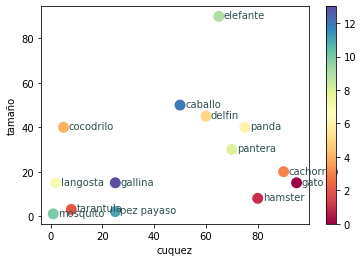

In [131]:
from matplotlib import cm

fig, ax = plt.subplots()
# animals.plot('cuquez', 'tamaño', kind='scatter', ax=ax) feeeo

cmap = cm.get_cmap('Spectral')
animals.plot('cuquez', 'tamaño', kind='scatter', ax=ax, s=120, linewidth=0, 
        c=range(len(animals)), colormap=cmap)

for k, v in animals.iterrows():
    ax.annotate(k, v,
                xytext=(5,-2), textcoords='offset points',
                family='sans-serif', fontsize=10, color='darkslategrey')

fig.canvas.draw()


Vemos que quiza el oso panda es lo mas parecido en tamaño y cuquez. No va desencaminado. La medida que estamos usando intuitivamente es la distancia euclídea:


In [132]:
#para que nos muestre todo.
InteractiveShell.ast_node_interactivity = "all"

import math
def deuclidea2D(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# entre pantera y panda 
deuclidea2D(70, 30, 75, 40)

# vs pantera y delfin que nos da la impresion que puede ser mas cerca
deuclidea2D(70, 30, 60, 45)



18.027756377319946

Podemos entonces usar esta medida para diferenciar entre ellos: la diferencia entre hamster y tarantula son 75 unidades de cuquez y un par de tamaño. Si trazamos una flecha ese vector seria su diferencia.

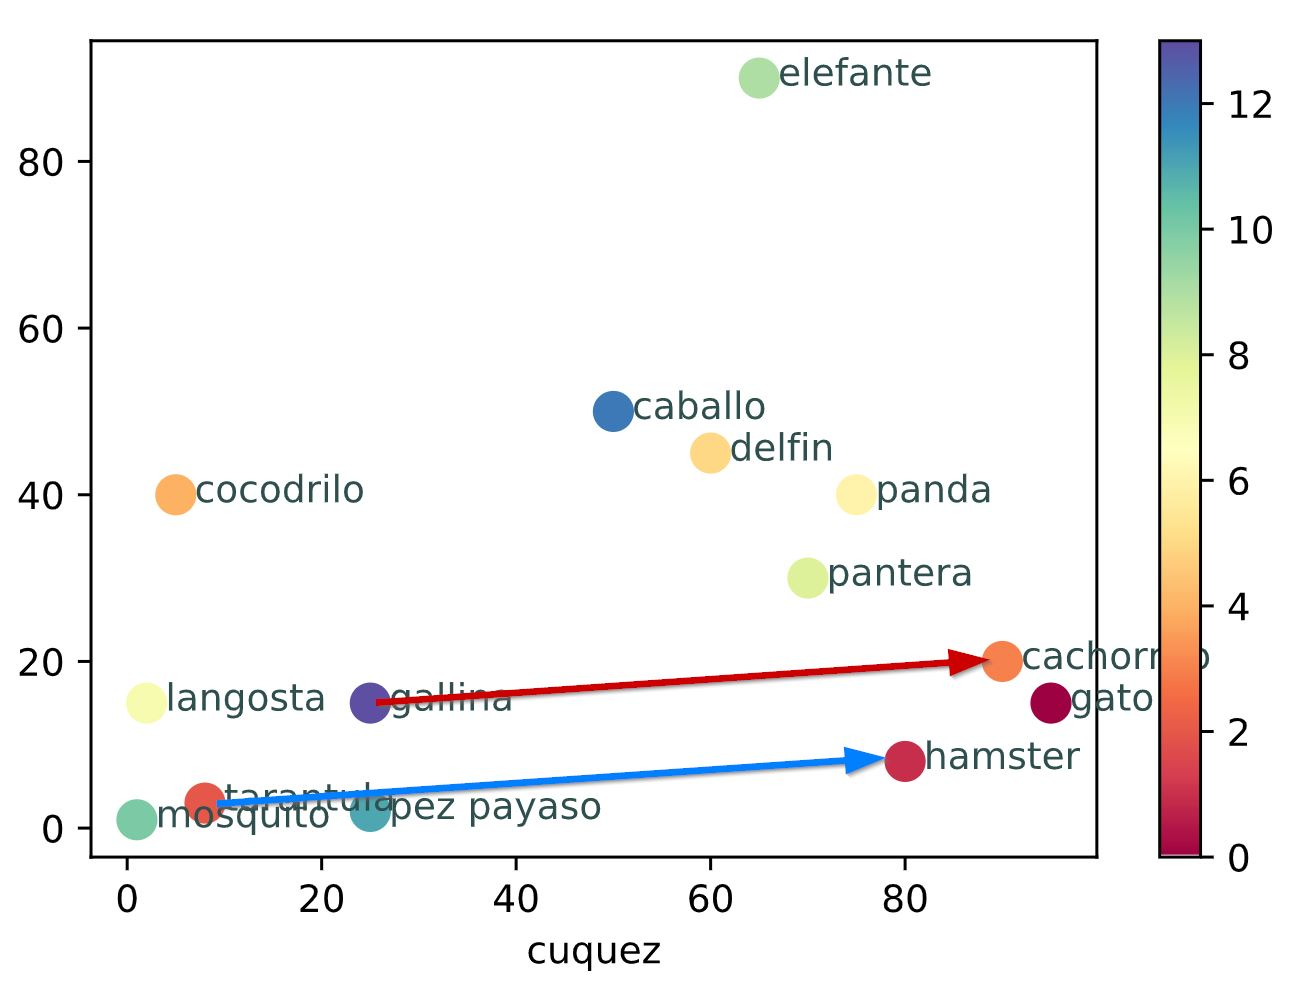

72.17340230306452

65.19202405202648

In [133]:
Image("./tarantulasvshamsters.jpg")

#tarantula - hamster
deuclidea2D(8, 3, 80, 8)

#tarantula - hamster
deuclidea2D(25, 15, 90, 20)

Es mas, podriamos argumentar que las tarántulas son a los hamsters lo que las gallinas a los cachorros, en modulo direccion y sentido. Podemos hacer mas cosas:

- ver que animal esta entre dos dados (caballo entre elefante y gallina)
- que animal esta mas cerca de ser 30 de grande y 10 de cuco (el cocodrilo)

## _Palabrovectores_ de colores

Los colores ya vienen representados por vectores, ya sea RGB HSV, asi que podriamos responder que colores son similares, cual es el nombre mas acertado para un vector dado de RGB. [xkcd] (https://xkcd.com/color/rgb) hizo una encuesta para dar nombres a colores —_lo siento, en ingles y son *muchos*: no los voy a traducir_— asi que trabajaremos con su csv: [https://github.com/dariusk/corpora/blob/master/data/colors/xkcd.json](https://github.com/dariusk/corpora/blob/master/data/colors/xkcd.json)

Unas notas antes de continuar: 

- Las funciones de algebra lineal implementadas aqui (addv, meanv) tienen todas su equivalente super-rapido en numpy: aquí se programam por tema didactico.
- Y para verdaderas funciones con color de python usa la libreria colormath
- Ir por favor a leer la página de xkcd y cuando os canseis de su paranoia con el color, bajar al final del todo a los "nombres de colores raros"


In [134]:
InteractiveShell.ast_node_interactivity = "last" # de vuelta a un resultado por página

import urllib.request, json 
with urllib.request.urlopen("https://raw.githubusercontent.com/dariusk/corpora/master/data/colors/xkcd.json") as url:
    color_data = json.loads(url.read().decode())

# ejemplo:
#  {'color': 'ivory', 'hex': '#ffffcb'},
#   {'color': 'very light purple', 'hex': '#f6cefc'},
#   {'color': 'light navy', 'hex': '#155084'},
#   {'color': 'pink red', 'hex': '#f5054f'},
#   {'color': 'olive brown', 'hex': '#645403'},
#   {'color': 'poop brown', 'hex': '#7a5901'},
#   {'color': 'mustard green', 'hex': '#a8b504'},
#   {'color': 'ocean green', 'hex': '#3d9973'},
#   {'color': 'very dark blue', 'hex': '#000133'},
#   {'color': 'dusty green', 'hex': '#76a973'},
#   {'color': 'light navy blue', 'hex': '#2e5a88'},
#   {'color': 'minty green', 'hex': '#0bf77d'},
#   {'color': 'adobe', 'hex': '#bd6c48'},
#   {'color': 'barney', 'hex': '#ac1db8'},
#   {'color': 'jade green', 'hex': '#2baf6a'},
#   {'color': 'bright light blue', 'hex': '#26f7fd'}




In [135]:
## conversion de hex a vector de enteros dandole 'hex': '#f6cefc'
def hex_to_int(s):
    s = s.lstrip("#")
    return int(s[:2], 16), int(s[2:4], 16), int(s[4:6], 16)


# diccionario con los colores y su valor en vector
colors = dict()
for item in color_data['colors']:
    colors[item["color"]] = hex_to_int(item["hex"])

#  'greeny brown': (105, 96, 6),
#  'lemon green': (173, 248, 2),
#  'light periwinkle': (193, 198, 252),
#  'seaweed green': (53, 173, 107),
#  'sunshine yellow': (255, 253, 55),
#  'ugly purple': (164, 66, 160),
#  'medium pink': (243, 97, 150),

colors["olive"]

(110, 117, 14)

## Operadores vectoriales

Antes de seguir, necesitamos las funciones de las que hablaba. La primera la distancia euclidea ete vectores, detrás el resto


In [136]:
import math

# distnacia enter vectores (módulo de su diferencia)
def distance(coord1, coord2):
    # note, this is VERY SLOW, don't use for actual code
    return math.sqrt(sum([(i - j)**2 for i, j in zip(coord1, coord2)]))

distance([10, 1], [5, 2])


5.0990195135927845

In [137]:
## diferencia de vectores

def subtractv(coord1, coord2):
    return [c1 - c2 for c1, c2 in zip(coord1, coord2)]
subtractv([10, 1], [5, 2])

[5, -1]

In [138]:
## suma de vectores

def addv(coord1, coord2):
    return [c1 + c2 for c1, c2 in zip(coord1, coord2)]
addv([10, 1], [5, 2])

[15, 3]

In [139]:
#media de corrdenacas

def meanv(coords):
    # assumes every item in coords has same length as item 0
    sumv = [0] * len(coords[0])
    for item in coords:
        for i in range(len(item)):
            sumv[i] += item[i]
    mean = [0] * len(sumv)
    for i in range(len(sumv)):
        mean[i] = float(sumv[i]) / len(coords)
    return mean
meanv([[0, 1], [2, 2], [4, 3]])

[2.0, 2.0]

In [140]:
# como test: es mayor la distancia entre rojo y verde que entre verde y rosa?

distance(colors['red'], colors['green']) > distance(colors['red'], colors['pink'])


True

## Busqueda del color más cercano.

Igual que con los animales, queremos el color mas cercano a un RGB dado. Lo mas sencillo (no lo mas rápido) bucar la distancia desde cada color y ordenar de menor a mayor. La funcion _closest()_ de aqui debajo hace justo eso y devuelve los diez más cercanos.  

**Nota:** Esto es _lento_ para uso de verdad mira las librerias de SciPy [kdtree](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.KDTree.html) or [Annoy](https://pypi.python.org/pypi/annoy).

In [141]:
def closest(space, coord, n=10):
    closest = []
    for key in sorted(  space.keys(),
                        key=lambda x: distance(coord, space[x])
                )[:n]:
        closest.append(key)
    return closest



Para probarla, la lanzzamos pasandole el diccionario y un color en RGB (chequea los resultados en https://xkcd.com/color/rgb/)

In [142]:
closest(colors, colors['red'])

['red',
 'fire engine red',
 'bright red',
 'tomato red',
 'cherry red',
 'scarlet',
 'vermillion',
 'orangish red',
 'cherry',
 'lipstick red']

In [143]:
closest(colors, [150, 60, 150])

['warm purple',
 'medium purple',
 'ugly purple',
 'light eggplant',
 'purpleish',
 'purplish',
 'purply',
 'light plum',
 'purple',
 'muted purple']

## magia de colores

La parte *magica* de esto es que las palabras parecen funcionar de la misma manera que sus vectores para las operaciones. Se pueden restar y sumar y el resultado se acerca.

In [144]:
### si sumamos componentes de rgb
supuesto_verde = addv(colors[ 'blue'], colors['gold'])
closest(colors, supuesto_verde)


['ice',
 'ice blue',
 'very pale blue',
 'very light blue',
 'really light blue',
 'pale blue',
 'light light blue',
 'duck egg blue',
 'eggshell blue',
 'light sky blue']

In [145]:
## no parece. Quizá azul más verde
closest(colors, addv(colors['blue'], colors['canary']))

['white',
 'pale grey',
 'ice blue',
 'very light blue',
 'very pale blue',
 'really light blue',
 'ice',
 'pale blue',
 'light light blue',
 'very light pink']

In [146]:
## lo que si funciona es la resta

closest(colors, subtractv(colors['purple'], colors['red']))

['cobalt blue',
 'royal blue',
 'darkish blue',
 'true blue',
 'royal',
 'prussian blue',
 'dark royal blue',
 'deep blue',
 'marine blue',
 'deep sea blue']

In [147]:
closest(colors, subtractv(colors['tea green'], colors['vibrant blue']))


['ugly yellow',
 'mustard',
 'snot green',
 'brownish yellow',
 'baby puke green',
 'bile',
 'mustard green',
 'muddy yellow',
 'puke',
 'bright olive']

No es perfecto, pero cuadra. podemos sacar la media entre blanco y negro

In [148]:
# the average of black and white: medium grey
closest(colors, meanv([colors['black'], colors['white']]))

['medium grey',
 'purple grey',
 'steel grey',
 'battleship grey',
 'grey purple',
 'purplish grey',
 'greyish purple',
 'steel',
 'warm grey',
 'green grey']

In [149]:
# the average of black and white: medium grey

igual que con la tarantula y el hamster, la gallina y el cachorro, podemos hacer la misma comparacion con colores

In [150]:
pink_to_red = subtractv(colors['pink'], colors['red'])
closest(colors, addv(pink_to_red, colors['blue']))

['neon blue',
 'bright sky blue',
 'bright light blue',
 'cyan',
 'bright cyan',
 'bright turquoise',
 'clear blue',
 'azure',
 'dodger blue',
 'lightish blue']

In [151]:
navy_to_blue = subtractv(colors['navy'], colors['blue'])
closest(colors, addv(navy_to_blue, colors['green']))

['true green',
 'dark grass green',
 'grassy green',
 'racing green',
 'forest',
 'bottle green',
 'dark olive green',
 'darkgreen',
 'forrest green',
 'grass green']

No es perfecto, pero parece que podemos demostrar que se puede usar algebra para razonar cómo usa la gente el lenguaje, incluso con algo tan subjetivo como los nombres de colores.

## Interludio: un poema de amor que pierde el norte.


In [152]:
import random
red = colors['red']
blue = colors['blue']
for i in range(14):
    rednames = closest(colors, red)
    bluenames = closest(colors, blue)
    print ("Roses are " + rednames[0] + ", violets are " + bluenames[0])
    red = colors[random.choice(rednames[1:])]
    blue = colors[random.choice(bluenames[1:])]

Roses are red, violets are blue
Roses are orangish red, violets are true blue
Roses are orange red, violets are royal blue
Roses are blood orange, violets are cobalt blue
Roses are reddish orange, violets are dark royal blue
Roses are tomato, violets are deep blue
Roses are strawberry, violets are darkblue
Roses are pinkish red, violets are navy blue
Roses are neon red, violets are night blue
Roses are reddish pink, violets are dark blue
Roses are pinkish red, violets are dark navy
Roses are pink red, violets are navy blue
Roses are lipstick, violets are dark blue
Roses are deep pink, violets are dark indigo


## obrando el mal con vectores de colores (y peleas con spaCy)

con las herramientas que hemos probado, vamos a aplicarlas a la literatura, vamos a usarlas con novela. Para las pruebas en ingles vamos a bajar en texto plano [Drácula](http://www.gutenberg.org/cache/epub/345/pg345.txt) y para las pruebas en español, y ya que no esta drácula traducido en el proyecto guttemberg, lo haremos con [el quijote](http://www.gutenberg.org/cache/epub/2000/pg2000.txt)

Bajamos el fichero a nuestro directorio y le quitamos la cabedera y el final en ingles, por no confundir y lo cortamos a la mitad, que es demasiado largo para parsear en casa.

Ante todo, cargamos la libreria [spaCy](https://spacy.io/), pip instalandola primero y cargando sus lenguajes

```` python
pip install spacy
python -m spacy download es
python -m spacy es_core_news_md
python -m spacy download en
````

En windows te puede aparecer al instalar:
```` python
Learning\machine_learning\.venv\lib\site-packages\spacy\data\es
⚠ Download successful but linking failed
Creating a shortcut link for 'es' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('es_core_news_sm')
````

Si eso ocurre usa nlp = spacy.load('es_core_news_sm') an vez de nlp = spacy.load('es') (con ingles habria que usar en_core_web_sm)

In [153]:
import spacy

nlpesp = spacy.load('es_core_news_md')


nlp = spacy.load('en_core_web_sm')




Si has conseguido que te funcione la celda previa: enhorabuena. 
Empecemos con el inglés. Si quisieramos calcular el color "medio" que aparece en Drácula, deberiamos de seguir estos pasos:

- Parsear el texto en palabras
- extraer los colores que aparezcan
- hacer su media
- extraer los colores mas cercanos al dado

In [154]:
doc = nlp(open("Dracula.txt").read())
# use word.lower_ to normalize case
drac_colors = [colors[word.lower_] for word in doc if word.lower_ in colors]
avg_color = meanv(drac_colors)
avg_color

[147.49555555555557, 113.63444444444444, 100.18333333333334]

In [155]:
closest(colors, avg_color)


['reddish grey',
 'brownish grey',
 'brownish',
 'brown grey',
 'mocha',
 'grey brown',
 'puce',
 'dull brown',
 'pinkish brown',
 'dark taupe']

Definitivamente oscuro. Si cogemos el libro [The Yellow Wallpaper](http://www.gutenberg.org/cache/epub/1952/pg1952.txt), de revelador nombre.

In [156]:
doc = nlp(open("yellow.txt").read())
# use word.lower_ to normalize case
yell_colors = [colors[word.lower_] for word in doc if word.lower_ in colors]
closest(colors, meanv(yell_colors))

['sickly yellow',
 'piss yellow',
 'puke yellow',
 'vomit yellow',
 'dirty yellow',
 'mustard yellow',
 'dark yellow',
 'olive yellow',
 'macaroni and cheese',
 'pea']

## Semántica distribucional
En las dos secciones anteriores, colores y animales, hemos podido trabajar por que nuestra representacion vectorial (RGB / cuquez+tamaño) daba valores cercanos a los colores/animales "cercanos". Podiamos llegar a decir que es una medida de su grado de sinónimos. Con los colores (que teniamos más), supongamos un buscador y que alguien busca pantalones malva (mauve trousers). Funcionalmente hablando, el buscador estaría acertado en buscar por:


In [157]:
for cname in closest(colors, colors['mauve']):
    print (cname + " trousers")

mauve trousers
dusty rose trousers
dusky rose trousers
brownish pink trousers
old pink trousers
reddish grey trousers
dirty pink trousers
old rose trousers
light plum trousers
ugly pink trousers


Pero eso está bien con los colores, que tienen una definición matemática (varias) muy clara. Que pasa con las palabras del quijote? Como puedes asignarles un vector de forma que las sinónimas esten más cerca, esto es, que proximidad en el espacio implique proximidad de significado.
¿Como se puede "medir" el significado? Una teoría muy popular entre los escritores de buscadores es la [Hipótesis Distribucional](https://en.wikipedia.org/wiki/Distributional_semantics) que dice que:

*las palabras con el mismo significado tienden a estar rodeadas de las mismas construcciones*

O como lo dicen ellos que suena mucho mas fino:

*los elementos linguisticos con la misma distribución tienen significados similares*

Donde *misma distribución* quiere decir que las encontramos en el mismo contexto. Pongamos por caso estas frases:

Ayer hizo mucho frio
Hoy va a hacer mucho calor
Va a hacer fresco el miercoles?
Y el finde, va a hacer bueno el finde?

frio, calor, fresco, hacer bueno, ... de acuerdo a la teoria distribucional deben estar relacionadas **de alguna manera**

E igualmente ayer, hoy, miércoles y finde tienen cierta relacion pues siempre aparecen en contextos de clima.

En otras palabras, de acuerdo a la teoría distribucional, el significado de una palabra es una enorme lista de contextos y, cuanto mas parecidos sean los contextos de dos palabras, más sinónimas serán.

## Vectorizar palabras contando contextos

Como mapear el contexto? imaginemos si cogemos la frase de dickens

It was the best of times, it was the worst of times.

y hacemos una tabla de este estilo:



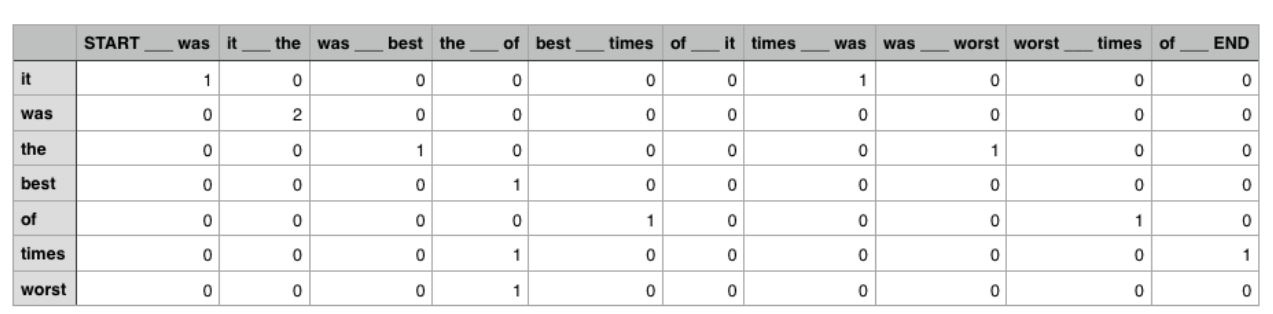

In [158]:
Image("./Dickens.jpg")

el vector de "it" dentro de esta frase es \[1,0,0,0,0,0,1,0,0,0\], el de "was" es \[0,2,0,0,0,0,0,0,0\], etc. Podemos incluso ver dos palabras con el mismo contexto \[0, 0, 0, 1, 0, 0, 0, 0, 0, 0\]: best y worst. En este caso no son sinónimos si no antónimos, pero es bastante acertado.

Ahora imaginemos hacer esto con todos los libros del proyecto guttemberg para un idioma. O con la wikipedia....

## Contextos y dimensionalidad

Podemos suponer que unos datos así se salen de madre muy rápido. Hay que reducir la dimensionalidad. Eso es relativamente sencillo, iterando los contextos similares, de forma que se acaban con espacios vectoriales de 300, 400 dimensiones. Algo más manejable.

Definir que es un contexto tb tiene su truco. En el ejemplillo de arriba se ha cogido la palabra anterior y la posterior. Podríamos coger dos antes y dos despues, saltar los artículos o aplicar algún método de [lematización](https://es.wikipedia.org/wiki/Lematizaci%C3%B3n) de forma que variaciones o conjugaciones de la misma palabra figuren como un único contexto.

## Espacios Vectoriales de GloVe 
Pero todo esto no lo tenemos que hacer, afortunadamente ya hay alguien que lo ha hecho por nosotros: [el proyecto GloVe de la Universidad de Stanford](https://nlp.stanford.edu/projects/glove/) sale en nuestra ayuda. Eso son los espacios que hemos cargado en spacy con los *python -m spacy download*

Tenemos nlp para el inglés y nlpesp para el español ya cargados.



In [159]:
## carguemos el quijote!!
doc = nlpesp(open("ElQuijote.txt", encoding="utf8").read())
quitokens = list(set([w.text for w in doc if w.is_alpha]))


In [160]:
nlpesp.vocab["burro"].vector

array([-0.004196, -0.880155, -1.014502, -0.602842,  0.567074,  0.38935 ,
       -0.434772, -0.758774, -0.532793,  0.393954, -0.191656, -0.17833 ,
       -0.224803, -1.361353,  1.083206,  0.107193,  0.367655,  0.926426,
        0.378849,  0.361274,  0.056926, -0.438431, -0.655965, -0.289202,
       -0.069906,  0.039555, -0.38169 ,  0.44933 ,  0.161568,  0.348674,
        0.768797,  0.197526, -0.060872,  0.559991,  0.547887,  0.961475,
        0.101642, -0.282506, -0.260703,  0.934616, -0.155027,  0.35884 ,
        0.268147, -0.805597, -0.33168 , -0.901739, -0.580274, -0.574598,
       -0.288886,  0.114869], dtype=float32)

In [161]:
# por comodidad vamos a poner una función que ante una palabra nos devuelva su vector

def vec(s):
    return nlpesp.vocab[s].vector

## encontrando los vecinos
La distancia escalar en vectores tan enormes pierde un poco su eficacia. existe una operacion llamada similaridad cosinoidal, que definimos aqui abajo. Hay muchas [más](http://www.uco.es/users/ma1fegan/Comunes/asignaturas/vision/Encyclopedia-of-distances-2009.pdf)

In [162]:


import numpy as np
from numpy import dot
from numpy.linalg import norm

# cosine similarity
def cosine(v1, v2):
    if norm(v1) > 0 and norm(v2) > 0:
        return dot(v1, v2) / (norm(v1) * norm(v2))
    else:
        return 0.0



In [163]:

#probemos
# vec('perro'),  vec('burro'), vec('pantalones'), vec('lanza')
cosine(vec('perro'), vec('burro')) > cosine(vec('pantalones'), vec('lanza'))


True

In [164]:
cosine(vec('perro'), vec('burro')) > cosine(vec('pantalones'), vec('camisa'))

False

La siguiente celda define una función de cercania, pero con el coseno en vez de con la dist euclidea. Vamos a usarla para buscar palabras cercanas a una dada, dentro de la novela del quijote

In [165]:
def spacy_closest(token_list, vec_to_check, n=10):
    return sorted(token_list,
                  key=lambda x: cosine(vec_to_check, vec(x)),
                  reverse=True)[:n]

In [166]:
# cuales son los eq mas cercanos a futbol? en *EL QUIJOTE*???
spacy_closest(quitokens, vec("futbol"))

['torneo',
 'rodeo',
 'aficionado',
 'encuentro',
 'duelo',
 'ganar',
 'liga',
 'juego',
 'pupilos',
 'afición']

Coño, premio!!

## Diversión con algebra vectorial y el Quijote
La suma, resta y media de vectores sigue siendo la misma fórmula para 3 que para n dimensiones asi que podemos localizar palabras entre la noche y el dia

In [167]:
spacy_closest(quitokens, meanv([vec("dia"), vec("noche")]))

['noche',
 'día',
 'mañana',
 'domingo',
 'días',
 'horas',
 'viernes',
 'semana',
 'tarde',
 'noches']

La mañana, la tarde, las horas! Tambien podemos localizar las palabras mas cercanas al caballero si le restamos... la espada (esto es contextos donde sale el caballero pero no sale la espada)

In [168]:
spacy_closest(quitokens, vec("caballero")), spacy_closest(quitokens, subtractv(vec("caballero"), vec("espada"))) 

(['ESCUDERO',
  'andante',
  'Caballero',
  'escudero',
  'caballero',
  'CABALLERO',
  'paje',
  'noble',
  'don',
  'Don'],
 ['capuchino',
  'Basilio',
  'nombrado',
  'nombró',
  'ESCUDERO',
  'andante',
  'Caballero',
  'escudero',
  'caballero',
  'CABALLERO'])

se nos  van los pajes y los nobles y el caballero andante, pero aparecen los capuchinos, Basilio y siguen el escudero y el caballero. Si le sumamos la espada, en cambio

In [169]:
spacy_closest(quitokens, addv(vec("caballero"), vec("espada"))) 

['ESCUDERO',
 'andante',
 'Caballero',
 'escudero',
 'caballero',
 'CABALLERO',
 'paje',
 'espada',
 'diestra',
 'hacha']

tenemos hacha, el paje y la diestra, la mano que la empuña.

In [170]:
caballero_sin_espada = subtractv(vec("caballero"), vec("espada"))
como_monje = addv(caballero_sin_espada, vec("monje"))
spacy_closest(quitokens, vec("monje")), spacy_closest(quitokens, como_monje)

(['abad',
  'Iglesia',
  'iglesia',
  'templo',
  'castillo',
  'Villadiego',
  'claustro',
  'Capilla',
  'capilla',
  'antiguo'],
 ['abad',
  'capuchino',
  'Basilio',
  'antiguo',
  'predicador',
  'clérigo',
  'católico',
  'patriarca',
  'alcaide',
  'obispo'])

In [171]:
 spacy_closest(quitokens, vec("loco")),spacy_closest(quitokens,  addv(subtractv(vec("caballero"), vec("espada")), vec("loco")))

(['cuerdo',
  'loco',
  'Loco',
  'descansado',
  'fatigado',
  'cabizbajo',
  'temeroso',
  'hacedme',
  'desengañado',
  'agobiado'],
 ['cuerdo',
  'loco',
  'Loco',
  'galán',
  'ESCUDERO',
  'andante',
  'Caballero',
  'escudero',
  'caballero',
  'CABALLERO'])

Parece que si al loco le damos la espada se vuelve caballero andante, galan o escudero.

## Similitud entre frases

El vector de la frase podemos definirlo como la media de sus componentes.


In [172]:
def sentvec(s):
    sent = nlpesp(s) #lista de vectores en mi frase
    return meanv([w.vector for w in sent])


In [173]:
frases = list(doc.sents)

# redefinimos la funcion de cercania con el coseno

def spacy_closest_sent(space, input_str, n=10):
    input_vec = sentvec(input_str)
    return sorted(space,
                  key=lambda x: cosine(np.mean([w.vector for w in x], axis=0), input_vec),
                  reverse=True)[:n]


In [174]:
for sent in spacy_closest_sent(frases, "Mi comida favorita es el vino con queso"):
    print (sent.text)
    print ("---")

-Como si fueran de vino tinto, pudiera vuestra merced decir mejor
-respondió Sancho-, porque quiero que sepa vuestra merced, si es que no lo
sabe, que el gigante muerto es un cuero horadado, y la sangre, seis arrobas
de vino tinto que encerraba en su vientre; y la cabeza cortada es la puta
que me parió, y llévelo todo Satanás.


---
-Aquí trayo una cebolla, y un poco de queso y no sé cuántos mendrugos de
pan -dijo Sancho-, pero no son manjares que pertenecen a tan valiente
caballero como vuestra merced.


---
tomara yo ahora más aína un cuartal
de pan, o una hogaza y dos cabezas de sardinas arenques, que cuantas yerbas
describe Dioscórides, aunque fuera el ilustrado por el doctor Laguna.
---
Pusiéronle la mesa a la puerta de la venta, por el fresco, y trújole el
huésped una porción del mal remojado y peor cocido bacallao, y un pan tan
negro y mugriento como sus armas; pero era materia de grande risa verle
comer, porque, como tenía puesta la celada y alzada la visera, no podía
poner nad

In [175]:
for sent in spacy_closest_sent(frases, "caballero valiente y osado con la espada"):
    print (sent.text)
    print ("---")

Aquí está don Quirieleisón de
Montalbán, valeroso caballero, y su hermano Tomás de Montalbán, y el
caballero Fonseca, con la batalla que el valiente de Tirante hizo con el
alano, y las agudezas de la doncella Placerdemivida, con los amores y
embustes de la viuda Reposada, y la señora Emperatriz, enamorada de
Hipólito, su escudero.
---
Viendo esto don Quijote, embrazó su adarga, y, puesta
mano a su espada, dijo:

-¡Oh señora de la fermosura, esfuerzo y vigor del debilitado corazón mío!

---
Murió a manos del rigor
   de una esquiva hermosa ingrata,
   con quien su imperio dilata
   la tiranía de su amor.


---
Sí,
que Gandalín, escudero de Amadís de Gaula, conde fue de la ínsula Firme; y
se lee dél que siempre hablaba a su señor con la gorra en la mano,
inclinada la cabeza y doblado el cuerpo more turquesco.
---
«Has de saber que una viuda
hermosa, moza, libre y rica, y, sobre todo, desenfadada, se enamoró de un
mozo motilón, rollizo y de buen tomo.
---
Y quiero que sepa
vuestra reveren


Further resources

    Word2vec is another procedure for producing word vectors which uses a predictive approach rather than a context-counting approach. This paper compares and contrasts the two approaches. (Spoiler: it's kind of a wash.)
    If you want to train your own word vectors on a particular corpus, the popular Python library gensim has an implementation of Word2Vec that is relatively easy to use. There's a good tutorial here.
    When you're working with vector spaces with high dimensionality and millions of vectors, iterating through your entire space calculating cosine similarities can be a drag. I use Annoy to make these calculations faster, and you should consider using it too.


